In [113]:
import pandas as pd
from math import atan2, degrees
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [143]:
# Loading the parquet data

parquet_data = pd.read_parquet('G:/My Drive/שנה ב/פרויקט מעבדה/StatesAnalysis/block3\predictions/front_head_only_resnet_152__top_20240117T141218.parquet', engine='fastparquet')
parquet_data = parquet_data.iloc[:,0:13]

In [145]:
# Calculate the angle of the head compared to the screen
def calculate_direction(x_ears, y_ears, x_nose, y_nose):
    delta_x = x_ears - x_nose
    delta_y = y_ears - y_nose
    
    # Calculate direction angle using arctangent
    angle_rad = atan2(delta_y, delta_x)

    # Convert angle from radians to degrees
    direction_angle = degrees(angle_rad)

    # Normalize the angle to be in the range [0, 360)
    direction_angle = (direction_angle + 360) % 360

    return direction_angle

In [146]:
# Creating the azimuth data from the parquet
def azimuth_creator(data):
    azimuth_angle_lst = []
    for i in range(len(data)):
        x_ears = data['mid_ears', 'cam_x'][i]
        y_ears = data['mid_ears', 'cam_y'][i]
        x_nose = data['nose', 'cam_x'][i]
        y_nose = data['nose', 'cam_y'][i]
        azimuth_angle_lst.append(calculate_direction(x_ears, y_ears, x_nose, y_nose))
    
    data['azimuth_angle'] = azimuth_angle_lst

In [269]:
# Executing the function on the parquet data
azimuth_creator(parquet_data)

In [208]:
# Loading the bug appearance frames from matlab (indicates on start and end of trial)
mat = loadmat('frames.mat')
frames = mat['frames']
frames = np.ndarray.tolist(frames)
start_frames = frames[0][0][0]
start_frames = np.ndarray.tolist(start_frames)
start_frames_lst = []
end_frames = frames[0][0][1]
end_frames_lst = []
for i in range(len(start_frames)):
    start_frames_lst.append(start_frames[i][0])
    end_frames_lst.append(end_frames[i][0])
frames_dict = {'Start': start_frames_lst, 'End': end_frames_lst}
frames_df = pd.DataFrame.from_dict(frames_dict)

In [191]:
# Loading the videoFrames data from matlab
arena_mat = loadmat('arenaCSV.mat')
arena_struct = arena_mat['CSV']
videoFrames = arena_struct['videoFrames'][0, 0]
videoFrames_data = pd.DataFrame(videoFrames, columns=['frame_num', 'timestamp'])
videoFrames_data['frame_num'] = videoFrames_data['frame_num'].apply(np.int64)

In [306]:
parquet_data['frame_num'] = list(videoFrames_data['frame_num'])

In [327]:
# Dividing the parquet data into trials
trials_lst = []
for index, row in frames_df.iterrows():
    trials_lst.append(parquet_data.loc[row[0] - 60:row[1] + 60])

# Setting time from zero column
for trial in trials_lst:
    time_diff = list(trial['time'].diff())
    time_diff[0] = 0
    time_from_zero = np.cumsum(time_diff)
    trial['time_from_zero'] = time_from_zero

C:\Users\OfekSapir\AppData\Local\Temp\ipykernel_42144\2384324011.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trials_lst.append(parquet_data.loc[row[0] - 60:row[1] + 60])
C:\Users\OfekSapir\AppData\Local\Temp\ipykernel_42144\2384324011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial['time_from_zero'] = time_from_zero


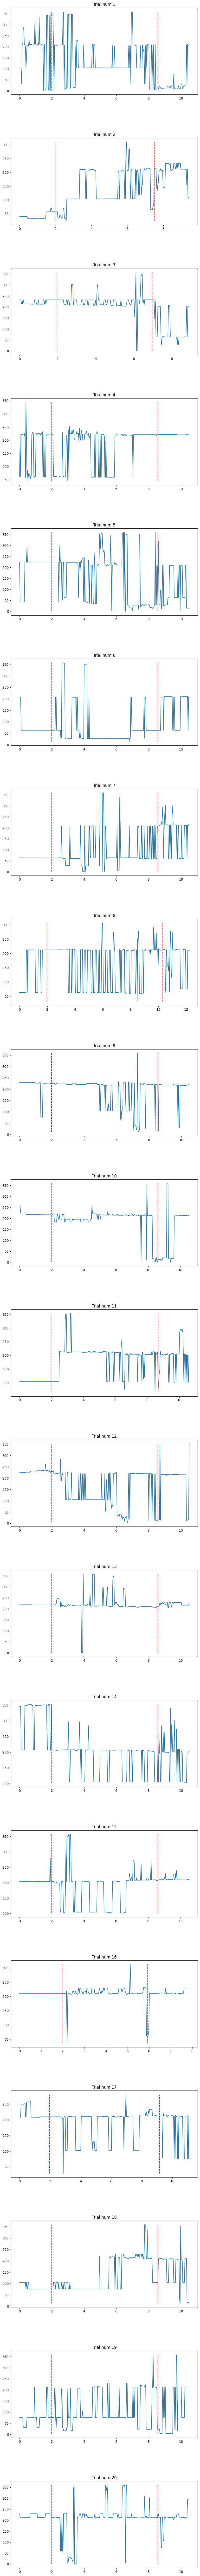

In [325]:
# Creating subplots of the azimuth data for each trial
fig, ax = plt.subplots(len(trials_lst), figsize=(10,138))
for i, trial in enumerate(trials_lst):
    ax[i].plot(trial['time_from_zero'], trial['azimuth_angle'])
    ax[i].set_title(f'Trial num {i+1}')
    x_start = trial['time_from_zero'].iloc[60]
    y_start = np.linspace(min(trial['azimuth_angle']), max(trial['azimuth_angle']), len(trial['time_from_zero']))
    x_end = trial['time_from_zero'].iloc[-60]
    y_end = np.linspace(min(trial['azimuth_angle']), max(trial['azimuth_angle']), len(trial['time_from_zero']))
    ax[i].plot([x_start] * len(y_start), y_start, color='red', linestyle='--')
    ax[i].plot([x_end] * len(y_end), y_end, color='red', linestyle='--')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

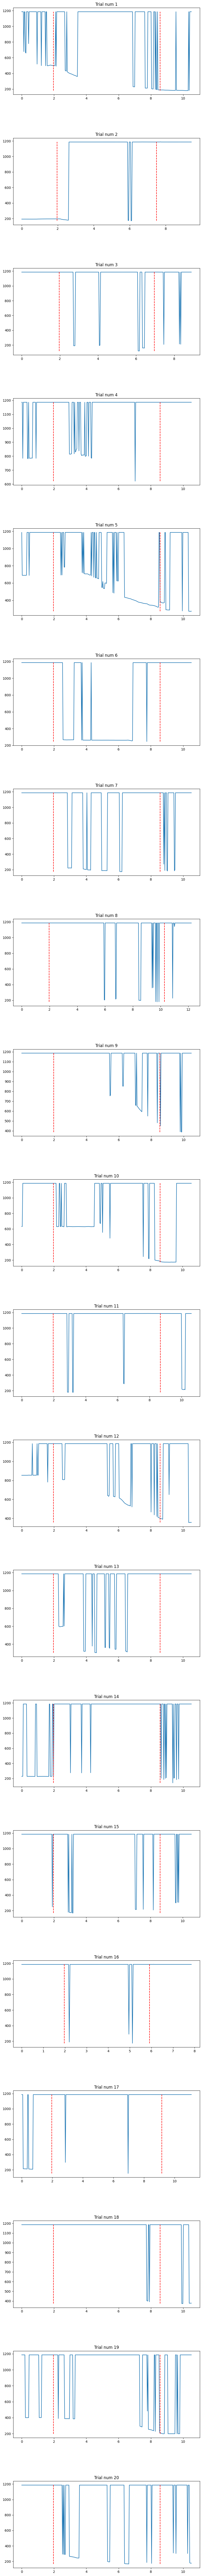

In [328]:
# Creating subplots of the distance from screen for each trial
fig, ax = plt.subplots(len(trials_lst), figsize=(10,138))
for i, trial in enumerate(trials_lst):
    ax[i].plot(trial['time_from_zero'], trial['nose', 'cam_x'])
    ax[i].set_title(f'Trial num {i+1}')
    x_start = trial['time_from_zero'].iloc[60]
    y_start = np.linspace(min(trial['nose', 'cam_x']), max(trial['nose', 'cam_x']), len(trial['time_from_zero']))
    x_end = trial['time_from_zero'].iloc[-60]
    y_end = np.linspace(min(trial['nose', 'cam_x']), max(trial['nose', 'cam_x']), len(trial['time_from_zero']))
    ax[i].plot([x_start] * len(y_start), y_start, color='red', linestyle='--')
    ax[i].plot([x_end] * len(y_end), y_end, color='red', linestyle='--')
    
plt.subplots_adjust(hspace=0.5)
plt.show()